In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
cond=y_train==0
taskA = {'data':x_train[cond], 'label':y_train[cond]}
cond=y_train ==1
taskB= {'data':x_train[cond],'label':y_train[cond]}
cond=y_train==2
taskC={'data':x_train[cond],'label':y_train[cond]}

In [ ]:
def model():
    l1=tf.keras.layers.Flatten(input_shape=(28,28))
    l2=tf.keras.layers.Dense(10,activation='softmax')
    mod=tf.keras.Sequential([l1,l2])
    mod.compile(loss='SparseCategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
    return mod
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.accA=[]
        self.accB=[]
    def on_epoch_end(self,epoch,logs=None):
        self.accB.append(logs['accuracy'])
        self.accA.append(logs['val_accuracy'])
        if logs['accuracy']==1.0:
            self.model.stop_training=1

nn=model()
            

In [ ]:
nn.fit(taskA['data']/255.0,taskA['label'],epochs=10)

Epoch 1/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0971 - accuracy: 1.0000
Epoch 2/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 1.0000
Epoch 3/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 1.0000
Epoch 4/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 5/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 1.0000
Epoch 6/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 7/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 8/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 9/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 10/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000

In [ ]:
theta= nn.weights
theta_star=nn.get_weights()

In [ ]:
lam=1
def compute_fisher(tasks):
    fisher=[np.zeros(v.get_shape().as_list())     for v in theta]
    for data in tasks:
        for i in range(len(data)//20):
            d=tf.reshape(data[i],(1,28,28))
            with tf.GradientTape() as g:
                g.watch(theta)
                probs=nn(d)
                y=tf.math.log(probs)
            ders=g.gradient(y,theta)
            for v in range(len(fisher)):
                fisher[v]+=tf.square(ders[v])
        for v in range(len(fisher)):
            fisher[v]/=len(data)//20
    return fisher            

fisher=compute_fisher([taskA['data']/255])
fisher

[<tf.Tensor: shape=(784, 10), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([80.93594   ,  0.99889314,  0.99931604,  0.9993807 ,  0.99947006,
         0.99942017,  0.99938315,  0.99892354,  0.99922293,  0.99888146],
       dtype=float32)>]

In [ ]:
@tf.function
def custom_loss(y_true,y_pred):
    loss=tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
    for v in range(len(theta)):
        loss+=(lam/2)*tf.reduce_sum(tf.multiply(fisher[v],tf.square(theta[v]-theta_star[v])))
    return loss
nn.compile(loss=custom_loss,optimizer='adam',metrics=['accuracy'])

In [ ]:
nn.evaluate(taskA['data']/255.0,taskA['label'])

186/186 [==============================] - 0s 1ms/step - loss: 3.4667e-04 - accuracy: 1.0000


[0.00034667245927266777, 1.0]

211/211 [==============================] - 0s 1ms/step - loss: 2.0851 - accuracy: 0.1023
Epoch 1/10
211/211 [==============================] - 1s 3ms/step - loss: 0.4329 - accuracy: 0.8917 - val_loss: 0.1113 - val_accuracy: 0.9998
Epoch 2/10
211/211 [==============================] - 1s 3ms/step - loss: 0.1698 - accuracy: 0.9837 - val_loss: 0.0769 - val_accuracy: 0.9998
Epoch 3/10
211/211 [==============================] - 1s 3ms/step - loss: 0.1317 - accuracy: 0.9864 - val_loss: 0.0657 - val_accuracy: 0.9998
Epoch 4/10
211/211 [==============================] - 1s 3ms/step - loss: 0.1113 - accuracy: 0.9874 - val_loss: 0.0554 - val_accuracy: 0.9998
Epoch 5/10
211/211 [==============================] - 1s 3ms/step - loss: 0.0985 - accuracy: 0.9877 - val_loss: 0.0497 - val_accuracy: 0.9998
Epoch 6/10
211/211 [==============================] - 1s 3ms/step - loss: 0.0897 - accuracy: 0.9892 - val_loss: 0.0453 - val_accuracy: 0.9998
Epoch 7/10
211/211 [==============================] - 1s 3m

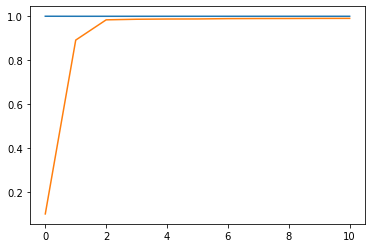

In [ ]:
cb=CustomCallback()
accA=[]
accB=[]
accA.append(nn.evaluate(taskA['data']/255.0,taskA['label'])[1])
accB.append(nn.evaluate(taskB['data']/255.0,taskB['label'])[1])
nn.fit(taskB['data']/255.0,taskB['label'],epochs=10,validation_data=(taskA['data']/255.0,taskA['label']),callbacks=[cb])
accA+=cb.accA
accB+=cb.accB
plt.plot(accA)
plt.plot(accB)
plt.show()

In [ ]:
fisher=compute_fisher([taskB['data']/255,taskA['data']/255])
fisher

[<tf.Tensor: shape=(784, 10), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([80.91954  ,  1.2626544,  1.0026857,  1.0027508,  1.0028404,
         1.0027912,  1.0027524,  1.002291 ,  1.002592 ,  1.0022497],
       dtype=float32)>]

In [ ]:
@tf.function
def custom_loss(y_true,y_pred):
    loss=tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
    for v in range(len(theta)):
        loss+=(lam/2)*tf.reduce_sum(tf.multiply(fisher[v],tf.square(theta[v]-theta_star[v])))
    return loss
nn.compile(loss=custom_loss,optimizer='adam',metrics=['accuracy'])

In [ ]:
nn.evaluate(taskA['data']/255.0,taskA['label'])
nn.evaluate(taskB['data']/255.0,taskB['label'])

211/211 [==============================] - 0s 1ms/step - loss: 0.3460 - accuracy: 0.9901


[0.346031129360199, 0.9900622963905334]

In [ ]:
cb=CustomCallback()
accA=[]
accB=[]
accC=[]
accA.append(nn.evaluate(taskA['data']/255.0,taskA['label'])[1])
accB.append(nn.evaluate(taskB['data']/255.0,taskB['label'])[1])
accC.append(nn.evaluate(taskC['data']/255.0,taskC['label'])[1])
nn.fit(taskC['data']/255.0,taskC['label'],epochs=10,validation_data=(taskB['data']/255.0,taskB['label']),callbacks=[cb])
accA+=cb.accA
accB+=cb.accB
accC+=cb.accC
plt.plot(accA)
plt.plot(accB)
plt.plot(accC)
plt.show()

187/187 [==============================] - 0s 1ms/step - loss: 13.5184 - accuracy: 0.0000e+00
Epoch 1/10
187/187 [==============================] - 1s 3ms/step - loss: 4.0824 - accuracy: 0.4762 - val_loss: 1.5183 - val_accuracy: 0.7913
Epoch 2/10
187/187 [==============================] - 1s 3ms/step - loss: 0.9335 - accuracy: 0.9780 - val_loss: 1.8305 - val_accuracy: 0.5122
Epoch 3/10
187/187 [==============================] - 1s 3ms/step - loss: 0.7410 - accuracy: 0.9807 - val_loss: 2.3640 - val_accuracy: 0.2378
Epoch 4/10
187/187 [==============================] - 1s 3ms/step - loss: 0.6407 - accuracy: 0.9773 - val_loss: 3.0454 - val_accuracy: 0.0767
Epoch 5/10
187/187 [==============================] - 1s 3ms/step - loss: 0.5814 - accuracy: 0.9757 - val_loss: 3.6086 - val_accuracy: 0.0251
Epoch 6/10
187/187 [==============================] - 1s 3ms/step - loss: 0.5436 - accuracy: 0.9718 - val_loss: 4.1547 - val_accuracy: 0.0059
Epoch 7/10
187/187 [==============================] - 

AttributeError: ignored